In [28]:
%pylab inline
from sys import platform
import pandas as pd
from datetime import datetime
from tqdm import tqdm, trange

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'
    
pd.options.mode.chained_assignment = None  # default='warn'
    
%run SentimentAnalysis.ipynb
%run GeoFeatures.ipynb

Populating the interactive namespace from numpy and matplotlib


/Users/ollyjc/Documents/GitHub/COVID-19-Sentiment-and-Compliance-Analyzer/.venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# EXPLORATORY ANALYSIS

from wordcloud import WordCloud

def cloud_gen(text):
    long_string = ','.join(list(text.values))

    wordcloud = WordCloud(background_color="white",
                          max_words=5000,
                          contour_width=3,
                          contour_color='steelblue'
                         )

    return wordcloud.generate(long_string)

In [66]:
### READS IN RAW REDDIT DATA FROM UNIVERSITY ONEDRIVE
### INTO COMMENT AND SUBMISSION DATAFRAMES

c_df = pd.read_csv(path + 'OneDrive - Cardiff University/Individual Project/raw data/comments.csv', index_col ='id')
s_df = pd.read_csv(path + 'OneDrive - Cardiff University/Individual Project/raw data/submissions.csv', index_col ='id')

In [29]:
### LOADS PROCESSED DATA

c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

In [ ]:
### ATTEMPT TO GEOCODE LOCATIONS FOR EACH SUBMISSION WHERE POSSIBLE

subs2geocode = s_df.sample(500)
subs2geocode['coords'] = get_captions([*subs2geocode['title'].values])

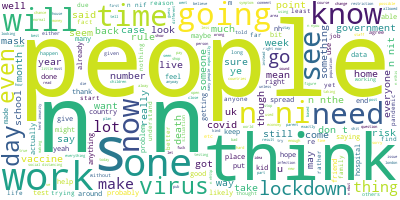

In [4]:
pt_wordcloud = cloud_gen(c_df['processed_text'])
pt_wordcloud.to_image()

In [ ]:
### PROCESSING OF RAW COMMENT AND SUBMISSION DATA

# Create a datetime from the 'created_utc' column of each row
c_df['datetime'] = [datetime.fromtimestamp(i) for i in c_df['created_utc']]
s_df['datetime'] = [datetime.fromtimestamp(i) for i in s_df['created_utc']]

In [ ]:
# Perform sentiment analysis on each comment and return the sentiment and compound score
c_df['sentiment'], c_df['compound_score'] = sentiment_analysis([*c_df['body']])

In [41]:
### QUERY DATAFRAME FOR NON NEUTRAL COMMENTS

c_df = c_df.query('sentiment != "neutral"')

In [27]:
# TEXT PREPROCESSING
import re

# REMOVING PUNCTUATION
c_df['processed_text'] = c_df['body'].map(lambda x: re.sub('[,\.!?]', '', x))

# SET ALL TEXT TO LOWERCASE
c_df['processed_text'] = c_df['processed_text'].map(lambda x: x.lower())

c_df['processed_text'].head()

id
fhaw2m3    Worrying part of the UK known cases are all pe...
fhawk4d    Surely it’s going to hit at all large multi-na...
fhawqrg    I’m not sure Bath is considered large It is in...
fhd9h84    Bath has quite a lot of Chinese students and a...
fhawwfz    Try screwfix and shops like that paint supplie...
Name: processed_text, dtype: object

In [39]:
comments = c_df.sample(100)

comments['happy'], comments['angry'], comments['suprise'], comments['sad'], comments['fear'] = get_emotions([*comments['processed_text']])

comments.sample(5)

,datetime,body,processed_text,sentiment,compound_score,submission_id,parent_id,happy,angry,suprise,sad,fear
id,,,,,,,,,,,,
g2vzp13,2020-08-26 08:07:37,I'm interested in this. I hope they continue t...,i'm interested in this i hope they continue th...,positive,0.9364,igni5i,t3_igni5i,0.12,0.04,0.25,0.21,0.38
fzis9d7,2020-07-28 16:37:26,"Where do I say anything close to ""let's have a...","where do i say anything close to ""let's have a...",negative,-0.0873,hz5h06,t1_fzifnuo,0.14,0.00,0.21,0.29,0.36
gaq1eje,2020-10-31 19:01:24,"Yes! I said this a few minutes ago, they are t...",yes i said this a few minutes ago they are the...,positive,0.6996,jlnwub,t1_gaq0wdm,0.00,0.00,0.67,0.33,0.00
gb5qrmq,2020-11-04 21:27:12,"Yeah, of course. All models are wrong, some ar...",yeah of course all models are wrong some are u...,positive,0.2500,jo48gk,t1_gb5q1z0,0.00,0.00,0.00,0.00,1.00
fo35z9j,2020-04-21 15:59:37,Haha good!,haha good,positive,0.7345,g5fqkt,t1_fo35m5h,1.00,0.00,0.00,0.00,0.00


In [39]:
# for index, row in tqdm(c_df.iterrows()):
#     row['happy'], row['angry'], row['suprise'], row['sad'], row['fear'] = get_emotions(row['body'])

# g = c_df.groupby(['submission_id'])['body'].transform(lambda x: ' '.join(x))
# g = c_df.groupby(['submission_id'])

for index, row in c_df.iterrows():
    top_level = 0
    if row['parent_id'][0:2] == 't3':
        top_level = 1
    c_df.at[index, 'top_level'] = top_level
    
c_df.sample(5)

# s_df = pd.merge(s_df, joined_sub_text, left_index=True, right_index=True)

# for i in trange(100):
#     get_emotions(c_df.iloc[i, 1])

# for group in grouped_submissions:
#     print(group[1])
# print('Done')

,datetime,body,processed_text,sentiment,compound_score,submission_id,parent_id,top_level
id,,,,,,,,
gen6m93,2020-12-04 22:41:00,Love the way you think this is unfair when you...,love the way you think this is unfair when you...,positive,0.7650,ja7vui,t1_g8odmnp,0
g6zd2af,2020-09-28 19:57:13,"Sure, reducing contact must be a factor in the...",sure reducing contact must be a factor in the ...,negative,-0.4588,j19v1u,t1_g6yago2,0
gcdlqas,2020-11-15 11:21:14,"That sounds awful and I feel for you, you’re i...",that sounds awful and i feel for you you’re in...,negative,-0.8020,juadte,t1_gcdb7ij,0
g025l8h,2020-08-02 06:20:40,"I have the symptoms of a cold, but not the thr...",i have the symptoms of a cold but not the thre...,positive,0.8625,i20956,t3_i20956,1
fkybypw,2020-03-19 19:21:43,Totally.\n\nThe government need to realise tha...,totally\n\nthe government need to realise that...,negative,-0.2584,flfjcr,t3_flfjcr,1


In [40]:
c_df.sample(5)

,datetime,body,processed_text,sentiment,compound_score,submission_id,parent_id,top_level
id,,,,,,,,
g4flwyc,2020-09-08 12:58:54,"The UK has about 40,000 total Covid deaths, ar...",the uk has about 40000 total covid deaths are ...,negative,-0.6440,ioo0h1,t1_g4f4m1x,0
gcyiq40,2020-11-20 17:17:43,I wonder how many will take it? I'm sure many ...,i wonder how many will take it i'm sure many w...,negative,-0.3182,jxro4p,t3_jxro4p,1
fppscxy,2020-05-07 00:36:49,In a year or two you'll looking back at this t...,in a year or two you'll looking back at this t...,negative,-0.6705,geupfz,t3_geupfz,1
fx4cxvm,2020-07-06 18:56:04,Think it helps because Swindon have had the lu...,think it helps because swindon have had the lu...,positive,0.3818,hmayna,t1_fx4bib5,0
ge9tktr,2020-12-01 16:37:46,Going back to hoping we don't have a pandemic ...,going back to hoping we don't have a pandemic ...,positive,0.5730,k4ll9f,t1_ge9qubp,0


In [30]:
for s_id, df in g:
    print(s_id)
    print(df['body'].transform(lambda x: ''.join(x)))

In [ ]:
c_df['happy'], c_df['angry'], c_df['suprise'], c_df['sad'], c_df['fear'] = get_emotions([*c_df['body']])

c_df.sample(5)

In [41]:
### REFORMAT DATAFRAMES

c_df = c_df[['datetime', 'body', 'processed_text', 'sentiment', 'compound_score', 'submission_id', 'parent_id', 'top_level']]
s_df = s_df[['datetime', 'title', 'selftext']]

In [43]:
### SAVE PROCESSED DATA

c_df.to_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df.to_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

In [42]:
c_df.sample(5)

,datetime,body,processed_text,sentiment,compound_score,submission_id,parent_id,top_level
id,,,,,,,,
fmwryp3,2020-04-09 18:06:16,100+ extra deaths? I’m sure that made them fee...,100+ extra deaths i’m sure that made them feel...,positive,0.6369,fxv9ae,t1_fmwmbgn,0
fl07jno,2020-03-20 09:03:52,The [Imperial paper](https://www.imperial.ac.u...,the [imperial paper](https://wwwimperialacuk/m...,negative,-0.8459,flpqxa,t3_flpqxa,1
fkrklmk,2020-03-17 18:45:03,I hope not:(,i hope not:(,positive,0.4404,fk5v56,t1_fkrkirf,0
ggpivsp,2020-12-22 17:21:04,"Yep, the timing look right",yep the timing look right,positive,0.2960,ki8vf7,t1_ggpgdea,0
fkjzyp8,2020-03-15 10:19:02,It’s a risky gamble and experiment while putti...,it’s a risky gamble and experiment while putti...,positive,0.4536,fiyx1j,t1_fkjz9ex,0
